# Práctica: CNN con CIFAR-10

---

## Contexto empresarial: DragonVision

La empresa tecnológica **DragonVision**, con sede en Shangai, está desarrollando una nueva
plataforma de **clasificación inteligente de imágenes**. El objetivo es crear modelos capaces de:

- Reconocer distintos tipos de objetos en imágenes de baja resolución.
- Reconstruir imágenes a partir de representaciones comprimidas (codificadas).

El departamento de I+D ha decidido usar el dataset **CIFAR-10**, un conjunto de imágenes pequeñas
(32x32 píxeles y 3 canales de color) que contiene 10 categorías distintas:

- Avión, automóvil, pájaro, gato, ciervo, perro, rana, caballo, barco, camión.

En esta práctica, tú formas parte del equipo de DragonVision y tu misión es:

1. Realizar un **análisis exploratorio** básico sobre el dataset CIFAR-10.
2. Diseñar, entrenar y evaluar una **red neuronal convolucional (CNN)** que clasifique correctamente estas imágenes.
3. Entregar un informe formato PDF

---

## Objetivos de aprendizaje

Al finalizar esta práctica deberías ser capaz de:

- Cargar y explorar un dataset de imágenes (`tf.keras.datasets.cifar10`).
- Entender la forma y el rango de valores de los tensores de imágenes.
- Diseñar una **CNN** simple para clasificación de imágenes:
  - Preparación de datos
  - Definición de la arquitectura
  - Compilación, entrenamiento, visualización de métricas
  - Evaluación en un conjunto de test
- Diseñar un **autoencoder convolucional** (encoder + decoder deconvolucional) que:
  - Comprima una imagen en un espacio latente
  - La reconstruya a partir de esa representación comprimida
- Interpretar una **batería de pruebas automáticas** sobre tus modelos y comprender por qué son aptos o no.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from sklearn.metrics import confusion_matrix

np.random.seed(42)

# Cargar el CIFAR-10 reducido desde un fichero local. El fichero debe estar en la misma ubicación que el notebook de python. Si no lo está, modificala tipo: np.load("C:\cifar10_mini.npz")
data = np.load("cifar10_mini.npz")

x_train = data["X_train"]
y_train = data["y_train"]
x_val   = data["X_val"]
y_val   = data["y_val"]
x_test  = data["X_test"]
y_test  = data["y_test"]

# Nombres de las clases en el orden de CIFAR-10
class_names = [
    "avión", "automóvil", "pájaro", "gato", "ciervo",
    "perro", "rana", "caballo", "barco", "camión"
]


## 1. Análisis Exploratorio de Datos (EDA) en CIFAR-10

En este apartado explorarás el dataset CIFAR-10 para entender mejor:

- Cómo son las dimensiones de las imágenes.
- En qué rango se mueven los valores de los píxeles.
- Cómo se distribuyen las clases.
- Ejemplos visuales de varias imágenes con sus etiquetas.

Recuerda que estamos trabajando con **imágenes en color** de tamaño **32x32** y **3 canales**.


### 1.1 Formas y tipos básicos

In [2]:
# Objetivo: comprender la estructura de x_train, y_train, x_test, y_test.

# TODO:
# 1) Imprime el tipo de datos (dtype) de x_train y y_train.
# 2) Imprime el número de imágenes de entrenamiento y de test.
#    Pista: usa shape[0].

# Escribe tu código debajo de este comentario:
print("Tipo de datos de X_train:", x_train.dtype)
print("Tipo de datos de y_train:", y_train.dtype)

print("\nNúmero de imágenes de entrenamiento:", x_train.shape[0])
print("Número de imágenes de test:", x_test.shape[0])

print("\nTamaño de x_train:", x_train.shape)
print("Tamaño de y_train:", y_train.shape)
print("Tamaño de x_test:", x_test.shape)
print("Tamaño de y_test:", y_test.shape)

Tipo de datos de X_train: uint8
Tipo de datos de y_train: uint8

Número de imágenes de entrenamiento: 5000
Número de imágenes de test: 1000

Tamaño de x_train: (5000, 32, 32, 3)
Tamaño de y_train: (5000, 1)
Tamaño de x_test: (1000, 32, 32, 3)
Tamaño de y_test: (1000, 1)


### 1.2 Rango de valores de los píxeles

In [3]:
# Objetivo: saber cuál es el valor mínimo y máximo de los píxeles (antes de normalizar).

# TODO:
# 1) Calcula el valor mínimo de x_train.
# 2) Calcula el valor máximo de x_train.
#    Pista: utiliza np

# Escribe tu código debajo:
np.min(x_train) 
np.max(x_train)

print("Valor mínimo en x_train:", np.min(x_train))
print("Valor máximo en x_train:", np.max(x_train))


Valor mínimo en x_train: 0
Valor máximo en x_train: 255


### 1.3 Distribución de clases

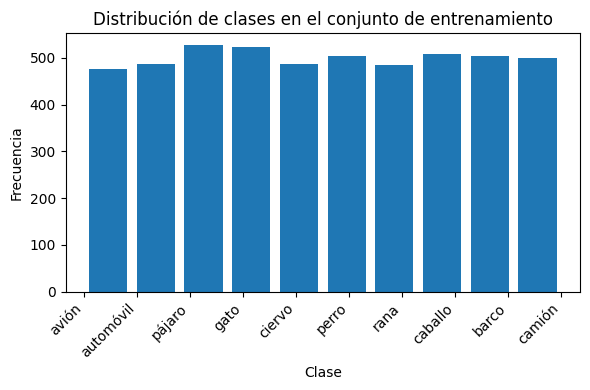

In [4]:
# Objetivo: comprobar cuántas imágenes hay de cada clase en el conjunto de entrenamiento.

# y_train tiene forma (num_imágenes, 1). Para contar, conviene aplanarlo:
y_train_flat = y_train.flatten()

# TODO:
# Muestra el resultado de forma legible, indicando el nombre de la clase.
# Ejemplo de salida:
#   Clase 0 (avión): 5000 imágenes
#   Clase 1 (automóvil): 5000 imágenes

# Pista: puedes recorrer con un bucle for y usar class_names[i].

# Escribe tu código debajo:
plt.figure(figsize=(6,4))
plt.hist(y_train, bins=10, rwidth=0.8)
plt.xticks(range(10), class_names, rotation=45, ha="right")
plt.title("Distribución de clases en el conjunto de entrenamiento")
plt.xlabel("Clase")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

### 1.4 Visualización de algunas imágenes

C:\Users\Usuario\AppData\Local\Temp\ipykernel_15868\682747981.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(y_train[i])


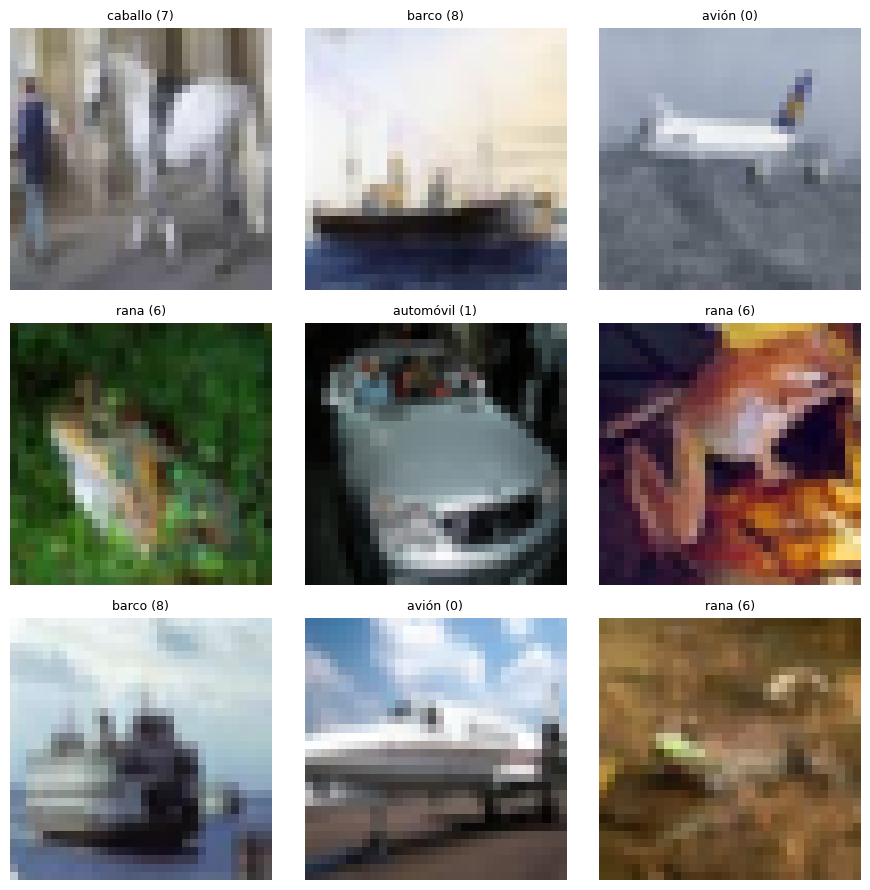

In [5]:
# Objetivo: visualizar varias imágenes con sus etiquetas para hacernos una idea del dataset.

# TODO:
# 1) Selecciona 'i' índices aleatorios del conjunto de entrenamiento.
# 2) Dibuja una cuadrícula 3x3 con plt.subplot(3, 3, i+1)
# 3) Usa plt.imshow() para mostrar la imagen (recuerda que son imágenes en color RGB).
# 4) Título: nombre de la clase (usa class_names[label]) y opcionalmente el índice.

# Pista: para quitar los ejes, usa plt.axis("off").

# Escribe tu código debajo:
plt.figure(figsize=(9,9))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i])
    label = int(y_train[i])
    plt.title(f"{class_names[label]} ({label})", fontsize=9)
    plt.axis("off")

plt.tight_layout()
plt.show()

### 1.5 De cara a enriquecer el PDF, comenta:

- Si las clases parecen balanceadas o no.
- Qué te llama la atención al ver las imágenes.
- Antes de crear la Red Neuronal, ¿por qué crees que puede ser un reto clasificar estas imágenes correctamente?
- A priori, ¿crees que será más fácil clasificar estas imágenes que las del catálogo de ropa?

---


## 2. Red Convolucional (CNN) para clasificación de CIFAR-10

En este bloque vas a construir una **CNN** capaz de predecir la clase de cada imagen de CIFAR-10.

Pasos a seguir:

1. Preparar los datos (normalización, posible reducción de tamaño del dataset, separación train/validación).
2. Diseñar la arquitectura de la CNN.
3. Compilar el modelo.
4. Entrenar la red (guardando el historial de entrenamiento).
5. Visualizar la evolución de las métricas (pérdida y accuracy).
6. Evaluar el modelo en el conjunto de test.

> OJO: para que el entrenamiento sea razonablemente rápido en los ordenadores del aula, es recomendable
> usar solo una parte de `x_train` (por ejemplo, 10.000 imágenes para entrenar y 2.000 para validación).
---


### 2.1 Preparación de datos para la CNN

In [6]:
# Recomendación (no obligatorio): reducir el tamaño del dataset para acelerar el entrenamiento (y que no te vaya a pedales el ordenador).

# Pistas:
# - Usa slicing.
# - Normaliza los píxeles al rango [0, 1] dividiendo entre 255.0.

# Nombres de variables:
# - X_train_cnn, y_train_cnn
# - X_val_cnn,   y_val_cnn
# - X_test_cnn,  y_test_cnn

# TODO:
# 1) Crear subconjunto de entrenamiento y validación a partir de x_train, y_train.
# 2) Normalizar X_train_cnn, X_val_cnn y X_test_cnn al rango [0,1].
# 3) Asegurarte de que y_train_cnn, y_val_cnn y y_test_cnn tienen un formato válido para Keras.

# Escribe tu código debajo:
"""X_train = x_train.astype("float32") / 255.0
X_test = x_test.astype("float32") / 255.0

X_train = X_train.reshape(-1, 32, 32, 3)
X_test = X_test.reshape(-1, 32, 32, 3)

print("Nueva forma de X_train:", X_train.shape)
print("Nueva forma de X_test:", X_test.shape)

# 4.3: Crear conjunto de validación (por ejemplo, las primeras 7.500 imágenes)
X_val = X_train[:5000]
y_val = y_train[:5000]

X_train_small = X_train[5000:]
y_train_small = y_train[5000:]

print("X_train_small:", X_train_small.shape)
print("X_val:", X_val.shape)"""

# 1) Crear subconjunto de entrenamiento y validación
#    (por ejemplo: 4.000 para entrenamiento y 1.000 para validación)

X_train_cnn = x_train[:5000]
y_train_cnn = y_train[:5000]

X_val_cnn = x_train[4000:5000]
y_val_cnn = y_train[4000:5000]

# El test se usa completo
X_test_cnn = x_test
y_test_cnn = y_test

# 2) Normalizar al rango [0,1]
X_train_cnn = X_train_cnn.astype("float32") / 255.0
X_val_cnn   = X_val_cnn.astype("float32") / 255.0
X_test_cnn  = X_test_cnn.astype("float32") / 255.0

# 3) Asegurar formato correcto para Keras (enteros)
y_train_cnn = y_train_cnn.astype("int32")
y_val_cnn   = y_val_cnn.astype("int32")
y_test_cnn  = y_test_cnn.astype("int32")

# Mostrar formas finales
print("X_train_cnn:", X_train_cnn.shape)
print("y_train_cnn:", y_train_cnn.shape)

print("X_val_cnn:", X_val_cnn.shape)
print("y_val_cnn:", y_val_cnn.shape)

print("X_test_cnn:", X_test_cnn.shape)
print("y_test_cnn:", y_test_cnn.shape)



X_train_cnn: (5000, 32, 32, 3)
y_train_cnn: (5000, 1)
X_val_cnn: (1000, 32, 32, 3)
y_val_cnn: (1000, 1)
X_test_cnn: (1000, 32, 32, 3)
y_test_cnn: (1000, 1)


### 2.2 Diseño de la arquitectura CNN

In [209]:
# En esta celda debes definir una red convolucional que reciba imágenes de tamaño (32, 32, 3)
# y produzca una salida de 10 clases.
#
# Sugerencias:
# - Uso de keras.Sequential()
# - Capas tipo Conv2D, MaxPooling2D, Flatten, Dense y si lo crees necesario (Dropout, etc.)

# El modelo DEBE llamarse: cnn_model

# Ejemplo de estructura (solo guía, NO copiar literalmente):
# cnn_model = keras.Sequential([
#     layers.Conv2D(...),
#     layers.MaxPool2D(...),
#     ...
#     layers.Flatten(),
#     layers.Dense(...),
#     layers.Dense(10, activation="softmax")
# ])

# TODO: define aquí tu modelo cnn_model

# Después de definirlo, muestra un resumen del modelo con summary()

cnn_model = keras.Sequential()

cnn_model.add(layers.Input(shape=(32, 32, 3)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
cnn_model.add(layers.MaxPool2D((2, 2)))

# Segunda capa de convolución + max pooling
cnn_model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
cnn_model.add(layers.MaxPool2D((2, 2)))

# (Opcional) tercera convolución para extraer características más complejas
cnn_model.add(layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
cnn_model.add(layers.MaxPool2D((2, 2)))

cnn_model.add(layers.Conv2D(256, (3, 3), activation="relu", padding="same"))
cnn_model.add(layers.MaxPool2D((2, 2)))

# Aplanar y capas densas finales
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(128, activation="relu"))
#model.add(layers.Dropout(0.5))  # para reducir sobreajuste
cnn_model.add(layers.Dense(10, activation="softmax"))

# Al final, mostrar el resumen del modelo
cnn_model.summary()



Model: "sequential_50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_189 (Conv2D)         (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_178 (MaxPool  (None, 16, 16, 64)        0         
 ing2D)                                                          
                                                                 
 conv2d_190 (Conv2D)         (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_179 (MaxPool  (None, 8, 8, 64)          0         
 ing2D)                                                          
                                                                 
 conv2d_191 (Conv2D)         (None, 8, 8, 256)         147712    
                                                                 
 max_pooling2d_180 (MaxPool  (None, 4, 4, 256)       

### 2.3 Compilación de la CNN

In [210]:
# Ahora debes compilar el modelo indicada la función de pérdida, el optimizador y las métricas.

# Sugerencias:
# - Optimizador: "adam" (u otro que te guste).
# - Pérdida:
#    - "sparse_categorical_crossentropy" si tus etiquetas son enteros 0-9.
#    - "categorical_crossentropy" si has convertido las etiquetas a one-hot.
# - Métricas: ["accuracy"] para empezar.

# TODO: compila cnn_model con los parámetros que consideres adecuados.

# Ejemplo de guía (NO copiar literal):
# cnn_model.compile(
#     optimizer=...,
#     loss=...,
#     metrics=[...]
# )
optimizer_name = "adam"# TODO: prueba a cambiarlo
loss_name = "sparse_categorical_crossentropy"
metrics_list = ["accuracy"]  # TODO: puedes añadir más métricas si quieres

cnn_model.compile(
    optimizer=optimizer_name,
    loss=loss_name,
    metrics=metrics_list
)

### 2.4 Entrenamiento de la CNN

In [211]:
# Entrena tu modelo cnn_model usando los datos:
#   - X_train_cnn, y_train_cnn
#   - X_val_cnn,   y_val_cnn
#
# Es importante que guardes el historial de entrenamiento en una variable llamada history_cnn.

# Sugerencias:
# - epochs entre 5 y 20 (en función del tiempo que tengas y de la velocidad del ordenador).
# - batch_size típico: 64 o 128.

# TODO:
# 1) Entrenar el modelo cnn_model.
# 2) Guardar el resultado en history_cnn y usa fit.

#history_cnn = None  # reemplaza por el resultado de model.fit()
epochs = 22
batch_size = 64

history = cnn_model.fit(
    X_train_cnn, y_train_cnn,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_cnn, y_val_cnn),
    verbose=1
)

Epoch 1/22
79/79 [==============================] - 6s 66ms/step - loss: 2.1208 - accuracy: 0.1918 - val_loss: 1.9672 - val_accuracy: 0.2500
Epoch 2/22
79/79 [==============================] - 5s 62ms/step - loss: 1.8197 - accuracy: 0.3174 - val_loss: 1.6738 - val_accuracy: 0.3750
Epoch 3/22
79/79 [==============================] - 5s 62ms/step - loss: 1.5850 - accuracy: 0.4150 - val_loss: 1.5111 - val_accuracy: 0.4240
Epoch 4/22
79/79 [==============================] - 5s 62ms/step - loss: 1.4160 - accuracy: 0.4768 - val_loss: 1.3416 - val_accuracy: 0.5090
Epoch 5/22
79/79 [==============================] - 5s 63ms/step - loss: 1.2936 - accuracy: 0.5210 - val_loss: 1.1624 - val_accuracy: 0.5770
Epoch 6/22
79/79 [==============================] - 5s 66ms/step - loss: 1.1507 - accuracy: 0.5912 - val_loss: 1.0134 - val_accuracy: 0.6240
Epoch 7/22
79/79 [==============================] - 5s 66ms/step - loss: 1.0443 - accuracy: 0.6246 - val_loss: 0.8877 - val_accuracy: 0.6930
Epoch 8/22
79

### 2.5 Visualización de la evolución del entrenamiento

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


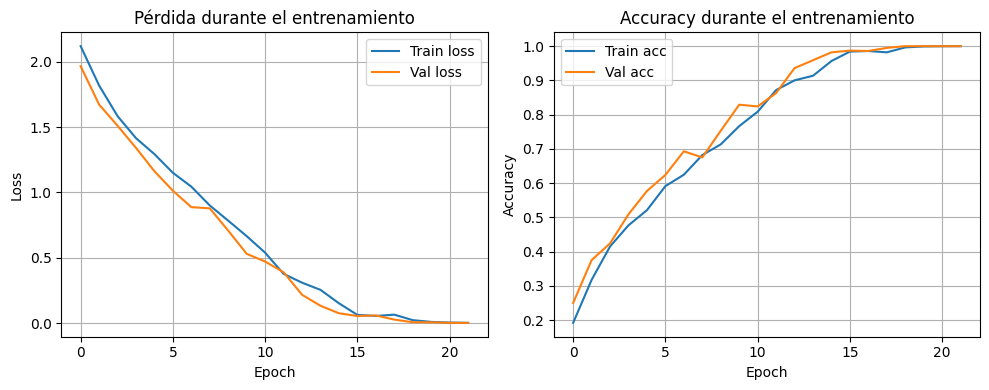

In [212]:
# A partir de history_cnn.history, representa:
# - La pérdida de entrenamiento y validación frente a las épocas.
# - La accuracy de entrenamiento y validación frente a las épocas (si la entrenaste).

# Pistas:
# - history_cnn.history es un diccionario con claves como "loss", "val_loss", "accuracy", "val_accuracy".
# - Puedes usar plt.plot() y plt.legend() para dibujar las curvas.

# TODO: dibuja las curvas de entrenamiento y validación (pérdida y accuracy).
history_dict = history.history
print(history_dict.keys())

plt.figure(figsize=(10,4))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="Train loss")
plt.plot(history_dict["val_loss"], label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Pérdida durante el entrenamiento")
plt.legend()
plt.grid(True)

# Accuracy (si existe)
if "accuracy" in history_dict:
    plt.subplot(1, 2, 2)
    plt.plot(history_dict["accuracy"], label="Train acc")
    plt.plot(history_dict["val_accuracy"], label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy durante el entrenamiento")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

### 2.6 Evaluación de la CNN en el conjunto de test

In [213]:
# Ahora evalúa tu modelo cnn_model en el conjunto de test (X_test_cnn, y_test_cnn)
# y muestra la pérdida y la accuracy finales.

# TODO:
# 1) Evalúa cnn_model en X_test_cnn, y_test_cnn.
# 2) Imprime los resultados de forma legible.

# Pista:
# test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn)
test_loss, test_acc = cnn_model.evaluate(X_test_cnn, y_test_cnn, verbose=0)

print(f"Pérdida en test: {test_loss:.4f}")
print(f"Accuracy en test: {test_acc:.4f}")

Pérdida en test: 2.4558
Accuracy en test: 0.6250


### En el informe de la práctica, incluye una sección dedicada a este bloque y responde de forma razonada con números a cuestiones como las siguientes:

> OJO: lo importante son los bloques, las preguntas como tal son sólo una guía para ayudarte a desarrollar el punto. Si respondes a algo más de lo que se pregunta, tendrás una mayor calificación

- **Preparación de datos**  
  Explica qué has hecho con el conjunto CIFAR-10 antes de entrenar:  
  - ¿Has usado todo el dataset o un subconjunto?  
  - ¿Cómo has normalizado las imágenes y por qué crees que es necesario hacerlo?

- **Diseño de la red**  
  Describe con tus palabras cómo es tu CNN: cuántas capas convolucionales y de pooling tiene, cuántas neuronas aproximadamente en la parte densa y qué papel crees que juegan las convoluciones y el pooling en este tipo de problemas de visión por ordenador.

- **Elección de hiperparámetros**  
  Comenta qué hiperparámetros clave has elegido (número de épocas, tamaño de batch, función de pérdida, optimizador…) y por qué te parecían opciones razonables para este problema. Si cambiaras alguno, ¿cuál sería y con qué objetivo?

- **Curvas de entrenamiento**  
  A partir de las gráficas de pérdida y accuracy (entrenamiento y validación), analiza cómo ha aprendido tu red:  
  - ¿Ves más signos de sobreajuste, de infraajuste o de un comportamiento razonable?  
  - ¿En qué detalles de las curvas te basas para llegar a esa conclusión?

- **Resultados en test y valoración global**  
  Resume los resultados numéricos que has obtenido en el conjunto de test y compáralos con los de entrenamiento y validación.  
  ¿Te parecen aceptables para un primer prototipo en la empresa DragonVision?  
  ¿Qué mejora concreta (de datos, arquitectura o entrenamiento) sería tu siguiente paso si tuvieras una sesión más de trabajo?

## 3. Análisis de errores de la CNN

Hasta ahora, hemos entrenado y evaluado nuestra red convolucional (CNN) para CIFAR-10,
pero solo nos hemos fijado en métricas agregadas como la **accuracy**.

En esta sección vamos a responder a preguntas más detalladas:

- ¿En qué clases acierta más la CNN?
- ¿En qué clases falla más?
- ¿Qué pares de clases se confunden con más frecuencia?
- ¿Cómo son visualmente algunas de las imágenes mal clasificadas?

Este análisis es clave en la empresa DragonVision para decidir en qué clases hay que
mejorar el modelo o recopilar más datos.

### 3.1 Cálculo de predicciones y matriz de confusión

In [214]:
# En esta celda vamos a:
# 1) Obtener las predicciones de la CNN sobre el conjunto de test.
# 2) Calcular la matriz de confusión usando sklearn.
#
# Recuerda:
# - y_test_cnn puede tener forma (N, 1), así que conviene aplanarlo con .flatten().
# - cnn_model.predict(X_test_cnn) te devuelve las probabilidades para cada clase.
# - np.argmax(..., axis=1) te da la clase de máxima probabilidad.
#
# Para la matriz de confusión vamos a usar sklearn.metrics.confusion_matrix.
# Pistas:
#   cm = confusion_matrix(y_true, y_pred)
#
# TODO:
# 1) Aplanar y_test_cnn en un vector y_true.
# 2) Calcular y_pred_proba con cnn_model.predict(X_test_cnn, ...).
# 3) Obtener y_pred a partir de y_pred_proba usando np.argmax(..., axis=1).
# 4) Calcular la matriz de confusión cm.
# 5) Imprimir las formas de y_true y y_pred, y mostrar cm por pantalla.

# TODO: 1) aplanar y_test_cnn
# y_true = ...
# print("Shape y_true:", y_true.shape)

# TODO: 2) obtener probabilidades de predicción de la CNN
# y_pred_proba = cnn_model.predict(...)

# TODO: 3) obtener clases predichas (enteros 0-9)
# y_pred = np.argmax(..., axis=1)
# print("Shape y_pred:", y_pred.shape)

# TODO: 4) calcular matriz de confusión
# cm = confusion_matrix(...)

# TODO: 5) imprimir la matriz de confusión
# print("Matriz de confusión (valores absolutos):")
# print(cm)
y_true = y_test.flatten()
print("Shape y_true:", y_true.shape)

y_pred_proba = cnn_model.predict(X_test_cnn, verbose=0)

y_pred = np.argmax(y_pred_proba, axis=1)
print("Shape y_pred:", y_pred.shape)

cm = confusion_matrix(y_true, y_pred)

print("Matriz de confusión (valores absolutos):")
print(cm)

Shape y_true: (1000,)
Shape y_pred: (1000,)
Matriz de confusión (valores absolutos):
[[74  1  7  1  0  0  2  1  2  2]
 [ 6 84  1  3  1  0  1  3  4 12]
 [ 8  2 70  8 11 10  4  2  2  1]
 [ 2  1 13 36 11 21  6  3  7  3]
 [ 2  2 12 12 57  4  3 10  3  1]
 [ 0  1 18 23  3 48  5  2  1  1]
 [ 0  0  5 11  6  1 69  0  0  1]
 [ 1  0  1  8 10  8  0 56  2  0]
 [ 7  3  2  2  1  1  2  1 66  2]
 [ 3 18  2  3  0  1  3  3  2 65]]


### 3.2. Dibujar la Matriz

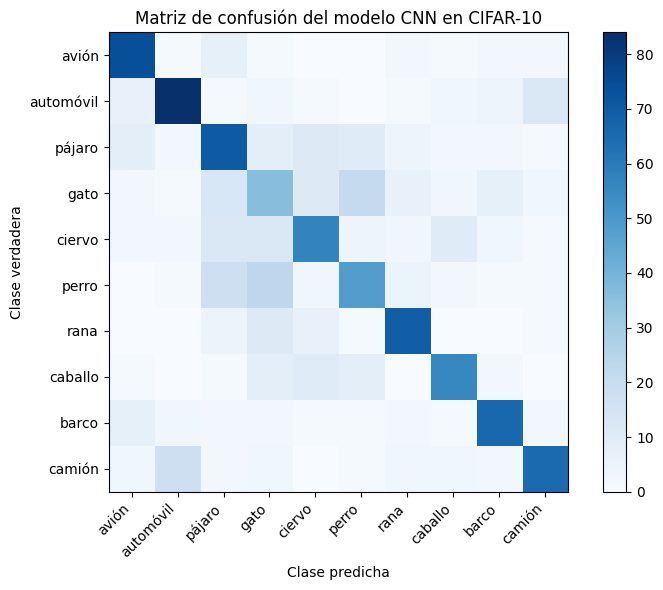

In [215]:
# En esta celda vas a representar la matriz de confusión cm como un mapa de calor.
#
# Pistas:
# - Usa plt.subplots() para crear la figura y los ejes.
# - Usa ax.imshow(cm, interpolation="nearest", cmap="Blues") para dibujar la matriz.
# - Añade una barra de color con plt.colorbar(im, ax=ax).
# - En el eje X: etiquetas de clases predichas.
# - En el eje Y: etiquetas de clases reales.
# - Usa ax.set_xticks(range(len(class_names))) y ax.set_xticklabels(class_names, rotation=45, ha="right").
# - Igual para el eje Y con set_yticks y set_yticklabels.
#
# TODO:
# 1) Crear la figura y los ejes.
# 2) Dibujar la matriz cm.
# 3) Añadir la barra de color.
# 4) Configurar ticks y etiquetas con class_names.
# 5) Añadir título y etiquetas de ejes.
# 6) Mostrar la figura.

# TODO: crear figura y ejes
# fig, ax = plt.subplots(...)

# TODO: dibujar la matriz de confusión
# im = ax.imshow(...)

# TODO: añadir barra de color
# plt.colorbar(...)

# TODO: configurar ticks y etiquetas (usa class_names)
# ax.set_xticks(...)
# ax.set_xticklabels(..., rotation=45, ha="right")
# ax.set_yticks(...)
# ax.set_yticklabels(...)

# TODO: añadir título y etiquetas de ejes
# ax.set_xlabel(...)
# ax.set_ylabel(...)
# ax.set_title(...)

# TODO: ajustar layout y mostrar
# plt.tight_layout()
# plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(cm, interpolation="nearest", cmap="Blues")
plt.colorbar(im, ax=ax) 
ax.set_xticks(range(len(class_names)))
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_yticks(range(len(class_names)))
ax.set_yticklabels(class_names)
ax.set_xlabel("Clase predicha")
ax.set_ylabel("Clase verdadera")
ax.set_title("Matriz de confusión del modelo CNN en CIFAR-10")
plt.tight_layout()
plt.show()


### 3.3 Aciertos por clases y visualización de clases mal clasificadas

Clase 0 (avión): accuracy = 0.8222  (muestras: 90)
Clase 1 (automóvil): accuracy = 0.7304  (muestras: 115)
Clase 2 (pájaro): accuracy = 0.5932  (muestras: 118)
Clase 3 (gato): accuracy = 0.3495  (muestras: 103)
Clase 4 (ciervo): accuracy = 0.5377  (muestras: 106)
Clase 5 (perro): accuracy = 0.4706  (muestras: 102)
Clase 6 (rana): accuracy = 0.7419  (muestras: 93)
Clase 7 (caballo): accuracy = 0.6512  (muestras: 86)
Clase 8 (barco): accuracy = 0.7586  (muestras: 87)
Clase 9 (camión): accuracy = 0.6500  (muestras: 100)

Mejor clase:
  0 (avión), accuracy = 0.8222
Peor clase:
  3 (gato), accuracy = 0.3495

=== Pares de clases más confundidas (real -> predicha) ===
Top 5 pares de clases más confundidas:

1. Real: 5 (perro)  Predicha: 3 (gato),  veces: 23
2. Real: 3 (gato)  Predicha: 5 (perro),  veces: 21
3. Real: 5 (perro)  Predicha: 2 (pájaro),  veces: 18
4. Real: 9 (camión)  Predicha: 1 (automóvil),  veces: 18
5. Real: 3 (gato)  Predicha: 2 (pájaro),  veces: 13

=== Visualización de algu

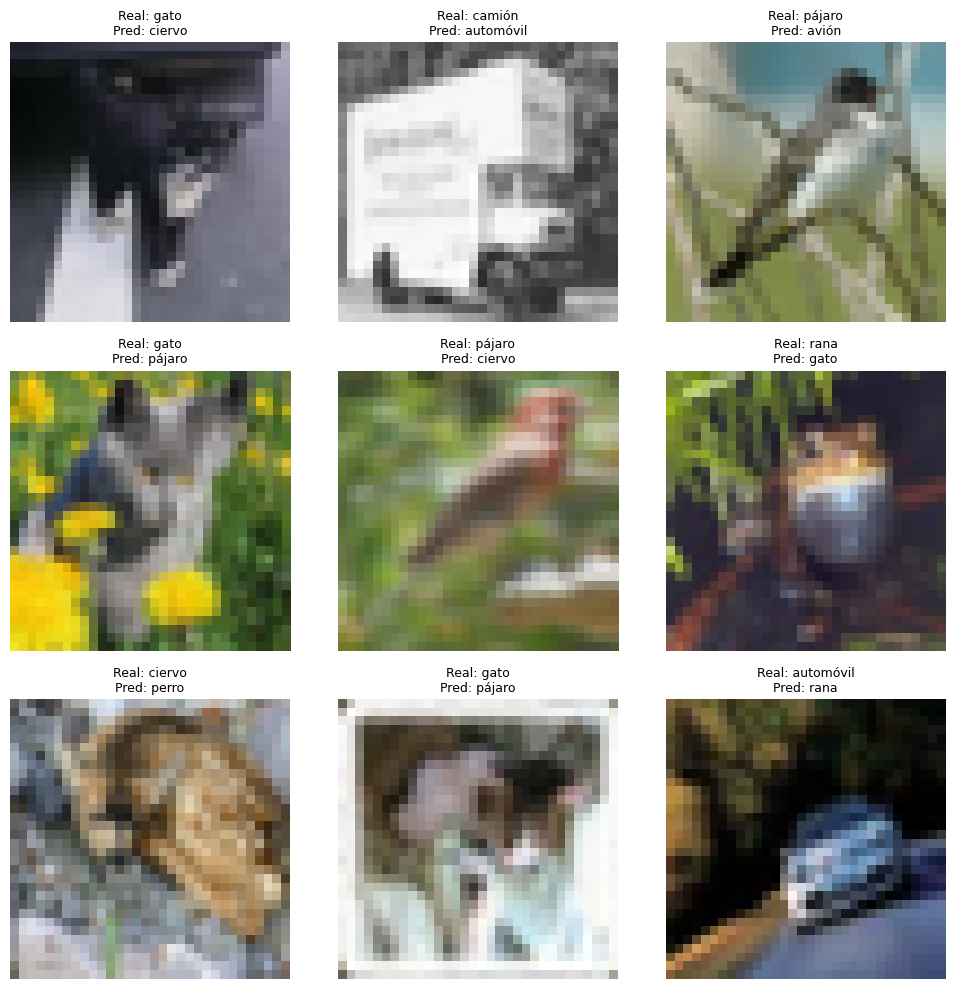

In [216]:
# Número de clases (debería coincidir con len(class_names) y cm.shape[0])
num_clases = len(class_names)

# Lista donde guardaremos la accuracy de cada clase
acc_por_clase = []

for c in range(num_clases):
    # Máscara booleana: True en las posiciones donde la etiqueta real es la clase c
    mask = (y_true == c)

    # Número total de muestras de la clase c
    total_c = mask.sum()

    if total_c == 0:
        # Por seguridad, si no hay muestras de esa clase (no debería pasar en CIFAR-10)
        acc_c = np.nan
    else:
        # Número de aciertos en la clase c
        aciertos_c = np.sum(y_pred[mask] == y_true[mask])
        # Accuracy de la clase c = aciertos / total
        acc_c = aciertos_c / total_c

    acc_por_clase.append(acc_c)

    print(f"Clase {c} ({class_names[c]}): accuracy = {acc_c:.4f}  (muestras: {total_c})")

# Índice de la mejor y peor clase (ignorando posibles NaN)
mejor_clase = int(np.nanargmax(acc_por_clase))
peor_clase = int(np.nanargmin(acc_por_clase))

print("\nMejor clase:")
print(f"  {mejor_clase} ({class_names[mejor_clase]}), accuracy = {acc_por_clase[mejor_clase]:.4f}")

print("Peor clase:")
print(f"  {peor_clase} ({class_names[peor_clase]}), accuracy = {acc_por_clase[peor_clase]:.4f}")

# ---------------------------------------------------------------------
# 3.4 Parejas de clases más confundidas
# ---------------------------------------------------------------------

print("\n=== Pares de clases más confundidas (real -> predicha) ===")

confusiones = []  # Lista de tuplas (clase_real, clase_predicha, veces_confundida)

# Recorremos todas las combinaciones de clases reales / predichas
for real in range(num_clases):
    for pred in range(num_clases):
        if real == pred:
            # La diagonal (real == pred) son aciertos, aquí buscamos SOLO errores
            continue

        # Veces que una imagen de clase 'real' se ha clasificado como 'pred'
        veces_confundida = cm[real, pred]

        if veces_confundida > 0:
            confusiones.append((real, pred, veces_confundida))

# Ordenamos la lista de confusiones de mayor a menor
confusiones_ordenadas = sorted(confusiones, key=lambda x: x[2], reverse=True)

# Mostramos las 5 confusiones más frecuentes
top_k = 5
print(f"Top {top_k} pares de clases más confundidas:\n")
for i in range(min(top_k, len(confusiones_ordenadas))):
    real, pred, veces = confusiones_ordenadas[i]
    print(f"{i+1}. Real: {real} ({class_names[real]})  "
          f"Predicha: {pred} ({class_names[pred]}),  veces: {veces}")

# ---------------------------------------------------------------------
# 3.5 Visualización de algunas imágenes mal clasificadas
# ---------------------------------------------------------------------

print("\n=== Visualización de algunas imágenes mal clasificadas ===")

# Índices de las muestras donde la CNN se ha equivocado
errores_idx = np.where(y_true != y_pred)[0]
num_errores = len(errores_idx)

print(f"Número total de imágenes mal clasificadas: {num_errores}")

if num_errores == 0:
    print("¡Enhorabuena! No se han encontrado errores en el conjunto de test.")
else:
    # Número de ejemplos a mostrar (puedes cambiar este valor si quieres ver más/menos)
    num_ejemplos = 9
    num_ejemplos = min(num_ejemplos, num_errores)

    # Seleccionamos índices aleatorios entre los errores
    ejemplos_idx = np.random.choice(errores_idx, size=num_ejemplos, replace=False)

    plt.figure(figsize=(10, 10))

    for i, idx in enumerate(ejemplos_idx):
        plt.subplot(3, 3, i + 1)

        # Imagen de test (ya normalizada en [0,1])
        img = X_test_cnn[idx]

        # Etiquetas real y predicha (enteros 0-9)
        real_label = y_true[idx]
        pred_label = y_pred[idx]

        plt.imshow(img)
        plt.axis("off")
        plt.title(
            f"Real: {class_names[real_label]}\nPred: {class_names[pred_label]}",
            fontsize=9
        )

    plt.tight_layout()
    plt.show()

### En el INFORME PDF escrito, responde a estas preguntas (no hace falta código aquí):

> OJO: lo importante son los bloques, las preguntas como tal son sólo una guía para ayudarte a desarrollar el punto. Si respondes a algo más de lo que se pregunta, tendrás una mayor calificación

¿Qué clases se clasifican mejor? ¿Cuáles peor?

¿Qué pares de clases se confunden más (real -> predicha)?

¿Qué posibles mejoras propondrías a la empresa para reducir esos errores?